In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [105]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Dropout
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Reshape
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
def prepare_data(data, image_folder, mask_folder):
    X = []
    Y = []
   
    for fig in data['Image']:
        # Load image
        img_path = os.path.join(image_folder, fig)
        img = Image.open(img_path).convert("RGB")
        img = img.resize((100, 100))
        x = np.array(img)
        x = preprocess_input(x)
       
        # Load mask if it exists
        mask_path = os.path.join(mask_folder, fig.split('.')[0] + '.png')
        if os.path.exists(mask_path):
            mask = Image.open(mask_path).convert("L")
            mask = mask.resize((100, 100))
            y = np.array(mask)
            y = y / 255.0  # Normalize mask values to [0, 1]
            y = y.reshape((100, 100, 1))
        else:
            y = np.zeros((100, 100, 1))  # Create empty mask for images without a corresponding mask
       
        X.append(x)
        Y.append(y)
   
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [ ]:
def prepare_test_data(data, image_folder, mask_folder):
    X = []
    Y = []
   
    for fig in data['Image']:
        # Load image
        img_filename = fig.split('.')[0] + '.jpg'
        img_path = os.path.join(image_folder, img_filename)
        if not os.path.isfile(img_path):
            continue
        img = Image.open(img_path).convert("RGB")
        img = img.resize((100, 100))
        x = np.array(img)
        x = preprocess_input(x)
       
        # Load mask if it exists
        mask_filename = fig.split('.')[0] + '.png'
        mask_path = os.path.join(mask_folder, mask_filename)
        if os.path.isfile(mask_path):
            mask = Image.open(mask_path).convert("L")
            mask = mask.resize((100, 100))
            y = np.array(mask)
            y = y / 255.0  # Normalize mask values to [0, 1]
            y = y.reshape((100, 100, 1))
        else:
            y = np.zeros((100, 100, 1))  # Create empty mask for images without a corresponding mask
       
        X.append(x)
        Y.append(y)
   
    X = np.array(X)
    Y = np.array(Y)
    return X, Y


In [ ]:

# Load train dataset
train_images_folder = '/content/drive/MyDrive/Colab Notebooks/cv_project/SBU-Train/ShadowImages/'
train_masks_folder = '/content/drive/MyDrive/Colab Notebooks/cv_project/SBU-Train/ShadowMasks/'
train_data = pd.DataFrame({'Image': os.listdir(train_images_folder)})
X_train, Y_train = prepare_data(train_data, train_images_folder, train_masks_folder)
X_train /= 255.0 

In [ ]:

# Load test dataset
test_images_folder = '/content/drive/MyDrive/Colab Notebooks/cv_project/SBU-Test/ShadowImages/'
test_masks_folder = '/content/drive/MyDrive/Colab Notebooks/cv_project/SBU-Test/ShadowMasks/'
test_data = pd.DataFrame({'Image': os.listdir(test_images_folder)})
X_test, Y_test = prepare_test_data(test_data, test_images_folder, test_masks_folder)
X_test /= 255.0

In [ ]:
model = Sequential()
model.add(Conv2D(32, (7, 7), strides=(1, 1), name='conv0', input_shape=(100, 100, 3)))
model.add(BatchNormalization(axis=3, name='bn0'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides=(1, 1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))
model.add(Flatten())
model.add(Dense(500, activation="relu", name='rl'))
model.add(Dropout(0.8))
model.add(Dense(100 * 100 * 1, activation='sigmoid', name='sigmoid'))
model.add(Reshape((100, 100, 1)))


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
128/128 [==============================] - 136s 1s/step - loss: 0.4371 - accuracy: 0.8060
Epoch 2/10
128/128 [==============================] - 133s 1s/step - loss: 0.4044 - accuracy: 0.8137
Epoch 3/10
128/128 [==============================] - 131s 1s/step - loss: 0.3880 - accuracy: 0.8182
Epoch 4/10
128/128 [==============================] - 132s 1s/step - loss: 0.3842 - accuracy: 0.8193
Epoch 5/10
128/128 [==============================] - 127s 995ms/step - loss: 0.3748 - accuracy: 0.8199
Epoch 6/10
128/128 [==============================] - 145s 1s/step - loss: 0.3678 - accuracy: 0.8224
Epoch 7/10
128/128 [==============================] - 132s 1s/step - loss: 0.3612 - accuracy: 0.8223
Epoch 8/10
128/128 [==============================] - 128s 1s/step - loss: 0.3612 - accuracy: 0.8240
Epoch 9/10
128/128 [==============================] - 134s 1s/step - loss: 0.3553 - accuracy: 0.8243
Epoch 10/10
128/128 [==============================] - 134s 1s/step - loss: 0.3552 - acc

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

20/20 [==============================] - 7s 329ms/step - loss: 0.3578 - accuracy: 0.8132
Loss: 0.35780036449432373
Accuracy: 0.8132389187812805


In [100]:
# Save the model
model.save('/content/drive/MyDrive/Colab Notebooks/cv_project/hmap_shadow_pred_model.h5')

In [122]:
#the code in this cell is for non-machine learning model, which is used for displaying results in comparision with that of using model

def load_image(image_path):
    # Load image from file path
    image = cv2.imread(image_path)
    image = cv2.resize(image, (100, 100))
    return image

def convert_to_lab(image):
    # Convert image to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    return lab_image

def threshold_l_channel(l_channel, kernel_size=5):
    # Compute mean value of L channel
    l_mean = np.mean(l_channel)

    # Compute standard deviation of L channel
    l_stddev = np.std(l_channel)

    # Threshold the L channel to create a binary mask
    _, mask = cv2.threshold(l_channel, l_mean - l_stddev, 255, cv2.THRESH_BINARY_INV)

    # Fill holes in the mask using morphological closing operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    closed_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, kernel)

    return closed_mask

def create_shadow_mask_image(image, mask):
    # Convert image to grayscale and change data type
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)

    # Apply Gaussian blur to remove noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Compute the Sobel gradient in x and y direction
    grad_x = cv2.Sobel(blurred_image, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(blurred_image, cv2.CV_32F, 0, 1, ksize=3)

    # Compute the gradient magnitude and direction
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    grad_dir = np.arctan2(grad_y, grad_x)

    # Threshold the gradient magnitude and direction to create binary masks
    grad_mag_mask = cv2.threshold(grad_mag, 0, 255, cv2.THRESH_BINARY)[1]
    grad_dir_mask = cv2.threshold(grad_dir, np.pi/2 - 0.3, np.pi/2 + 0.3, cv2.THRESH_BINARY)[1]

    # Combine the masks to create a shadow mask
    shadow_mask = cv2.bitwise_and(grad_mag_mask, grad_dir_mask, mask=mask)

    # Set shadow region to white and non-shadow region to black
    shadow_mask[mask == 255] = 255
    shadow_mask[mask == 0] = 0

    return shadow_mask

1/1 [==============================] - 0s 39ms/step


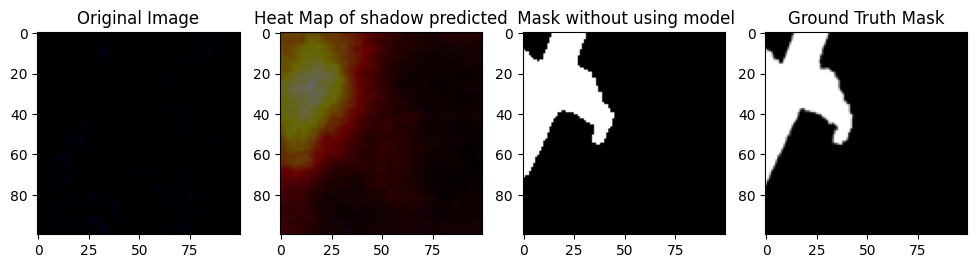

In [125]:
# Load and preprocess the new image
new_image_path = '/content/drive/MyDrive/Colab Notebooks/cv_project/SBU-Train/ShadowImages/lssd2.jpg'
non_model_image = load_image(new_image_path)
new_image = Image.open(new_image_path).convert("RGB")
new_image = new_image.resize((100, 100))
new_image = preprocess_input(np.array(new_image))
new_image /= 255.0

# Make predictions on the new image
predictions = model.predict(np.expand_dims(new_image, axis=0))

# Optionally, load and preprocess the ground truth mask
ground_truth_mask_path = '/content/drive/MyDrive/Colab Notebooks/cv_project/SBU-Train/ShadowMasks/lssd2.png'
ground_truth_mask = Image.open(ground_truth_mask_path).convert("L")
ground_truth_mask = ground_truth_mask.resize((100, 100))
ground_truth_mask = np.array(ground_truth_mask) / 255.0

# Set visualization parameters
smoke_alpha = 0.4  # Opacity of the predicted mask
smoke_cmap = 'hot'  # Colormap for the predicted mask

#non model

lab_image = convert_to_lab(non_model_image)

# Extract L channel from LAB color space
l_channel = lab_image[:, :, 0]

# Threshold L channel to create binary mask
mask = threshold_l_channel(l_channel, kernel_size=5)

# Create shadow mask
shadow_mask = create_shadow_mask_image(non_model_image, mask)
# Display the images
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

# Plot original image
axs[0].imshow(new_image)
axs[0].set_title('Original Image')

# Plot predicted mask with smoke effect
axs[1].imshow(new_image)
axs[1].imshow(predictions.squeeze(), cmap=smoke_cmap, alpha=smoke_alpha)
axs[1].set_title('Heat Map of shadow predicted')

# mask with out using model
axs[2].imshow(shadow_mask, cmap='gray')
axs[2].set_title(' Mask without using model')

# Plot ground truth mask (optional)
axs[3].imshow(ground_truth_mask.squeeze(), cmap='gray')
axs[3].set_title('Ground Truth Mask')

plt.show()
